Using data from nevena flat line removal

In [101]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
# --- Data Loading ---
directory_path = r'/home/ryan/Documents/CBI/nesscan_fixed_removed_flat_lines_03312025/bobHallPier'
dataframes = []
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(
            file_path,
            parse_dates=[0],
            na_values=[-999, -99, 99, 'NA', 'RM'],
            engine='python'
        )
        df.columns = ['date', 'pwl']
        dataframes.append(df)

bhp = pd.concat(dataframes, ignore_index=True)
bhp['date'] = pd.to_datetime(bhp['date'])
bhp = bhp[bhp['date'] >= pd.to_datetime('1996-01-01')]
bhp = bhp.reset_index(drop=True)

# --- Remove obvious outliers using ±4 from median ---
median_val = bhp['pwl'].median()
bhp.loc[np.abs(bhp['pwl'] - median_val) > 4, 'pwl'] = np.nan
pd.set_option("display.max_columns", None)

In [102]:

pwl = bhp['pwl']
s = lambda x: pwl.shift(x)

# --- Compute All 8 Third Differences ---
bhp['3DF']    = s(3)  - 3 * s(2)  + 3 * s(1)  - s(0)
bhp['3DFm1']  = s(4)  - 3 * s(3)  + 3 * s(2)  - s(0)
bhp['3DFm2']  = s(4)  - 3 * s(3)  + 3 * s(1)  - s(0)
bhp['3DFm3']  = s(4)  - 3 * s(2)  + 3 * s(1)  - s(0)

bhp['3DB']    = s(-3) - 3 * s(-2) + 3 * s(-1) - s(0)
bhp['3DBm1']  = s(-4) - 3 * s(-3) + 3 * s(-2) - s(0)
bhp['3DBm2']  = s(-4) - 3 * s(-3) + 3 * s(-1) - s(0)
bhp['3DBm3']  = s(-3) - 3 * s(-2) + 3 * s(-1) - s(0)

third_diff_cols = ['3DF', '3DFm1', '3DFm2', '3DFm3', '3DB', '3DBm1', '3DBm2', '3DBm3']
bhp[third_diff_cols] = bhp[third_diff_cols].round(4)

# Flag each 3D if it exceeds ±6 STD
def create_flag_column(df, col):
    std = df[col].std(skipna=True)
    mean = df[col].mean(skipna=True)
    upper = mean + 6 * std
    lower = mean - 6 * std

    return (
        (df[col].isna()) | 
        (df[col] == 0) | 
        (df[col] > upper) | 
        (df[col] < lower)
    ).astype(int)

third_diff_flag_cols = [f'{col}_flag' for col in third_diff_cols]
for col in third_diff_cols:
    bhp[f'{col}_flag'] = create_flag_column(bhp, col)

# Create suspect flag
bhp['suspect_flag'] = bhp[third_diff_cols].isna().all(axis=1).astype(int)

# Clean using only the third diff flags (not repeat/spike)
bhp['pwl_cleaned'] = np.where(
    bhp[third_diff_flag_cols].sum(axis=1) > 0,
    np.nan,
    bhp['pwl']
)
bhp.loc[bhp['suspect_flag'] == 1, 'pwl_cleaned'] = np.nan

false positive check

In [103]:
forward_flags  = ['3DF_flag', '3DFm1_flag', '3DFm2_flag', '3DFm3_flag']
backward_flags = ['3DB_flag', '3DBm1_flag', '3DBm2_flag', '3DBm3_flag']

bhp['false_positive_exception'] = (
    ((bhp[forward_flags].sum(axis=1) > 0) & (bhp[backward_flags].sum(axis=1) == 0)) |
    ((bhp[backward_flags].sum(axis=1) > 0) & (bhp[forward_flags].sum(axis=1) == 0))
).astype(int)

bhp.loc[bhp['false_positive_exception'] == 1, 'pwl_cleaned'] = bhp.loc[bhp['false_positive_exception'] == 1, 'pwl']


repeat check

In [104]:
for col in ['spike_pass', 'spike_repeat_flag', 'spike_flag']:
    if col not in bhp.columns:
        bhp[col] = 0

# Now get all flag columns (excluding suspect)
all_flag_cols = [col for col in bhp.columns if col.endswith('_flag') and col != 'suspect_flag']

# Get rows where any flag is set
flagged_rows = bhp[all_flag_cols].any(axis=1)
flagged_indices = bhp.index[flagged_rows]

for i in flagged_indices:
    spike_val = bhp.at[i, 'pwl']
    pass_val = bhp.at[i, 'spike_pass']
    if pd.isna(spike_val):
        continue

    # Forward
    j = i + 1
    while j < len(bhp) and bhp.at[j, 'pwl'] == spike_val:
        if bhp.loc[j, 'spike_flag'] == 0:
            bhp.at[j, 'spike_repeat_flag'] = 1
            bhp.at[j, 'spike_flag'] = 1
            bhp.at[j, 'spike_pass'] = pass_val
            bhp.at[j, 'pwl_cleaned'] = np.nan
        j += 1

    # Backward
    j = i - 1
    while j >= 0 and bhp.at[j, 'pwl'] == spike_val:
        if bhp.loc[j, 'spike_flag'] == 0:
            bhp.at[j, 'spike_repeat_flag'] = 1
            bhp.at[j, 'spike_flag'] = 1
            bhp.at[j, 'spike_pass'] = pass_val
            bhp.at[j, 'pwl_cleaned'] = np.nan
        j -= 1





Nan Check

In [105]:
third_diff_flag_cols = [f'{col}_flag' for col in third_diff_cols]
for col in third_diff_cols:
    bhp[f'{col}_flag'] = create_flag_column(bhp, col)

has_all_fwd = bhp[forward_flags].notna().sum(axis=1) == len(forward_flags)
has_all_bwd = bhp[backward_flags].notna().sum(axis=1) == len(backward_flags)

n_fwd = bhp[forward_flags].sum(axis=1)
n_bwd = bhp[backward_flags].sum(axis=1)

bhp['final_keep'] = (
    ((n_fwd > 0) & (n_bwd == 0) & has_all_bwd) |
    ((n_bwd > 0) & (n_fwd == 0) & has_all_fwd) |
    ((n_fwd == 0) & (n_bwd == 0))  # No flags at all
).astype(int)
bhp.loc[bhp['final_keep'] == 0, 'pwl_cleaned'] = np.nan


In [106]:
threshold = 2
bhp['gradient_flag'] = 0

pwl_values = bhp['pwl_cleaned'].values
n = len(pwl_values)
i = 1

while i < n:
    prev_val = pwl_values[i - 1]
    curr_val = pwl_values[i]

    if pd.isna(prev_val) or pd.isna(curr_val):
        i += 1
        continue

    diff = abs(curr_val - prev_val)

    if diff > threshold:
        # Spike detected
        baseline = prev_val
        bhp.at[i, 'gradient_flag'] = 1
        bhp.at[i, 'pwl_cleaned']  = np.nan

        # Forward check (only next 10 values)
        max_j = min(i + 10, n - 1)
        j = i + 1
        while j <= max_j:
            val = pwl_values[j]
            if pd.isna(val):
                j += 1
                continue

            if abs(val - baseline) > threshold:
                bhp.at[j, 'gradient_flag'] = 1
                bhp.at[j, 'pwl_cleaned']  = np.nan
                j += 1
            else:
                break  # value returned near-baseline

        i = j  # jump past the checked window
    else:
        i += 1



# Move pwl_cleaned to end
pwl_cleaned_col = bhp.pop('pwl_cleaned')
bhp['pwl_cleaned'] = pwl_cleaned_col

bhp = bhp.drop(columns=['spike_pass', 'spike_flag','final_keep'])

Text(0, 0.5, 'Freq')

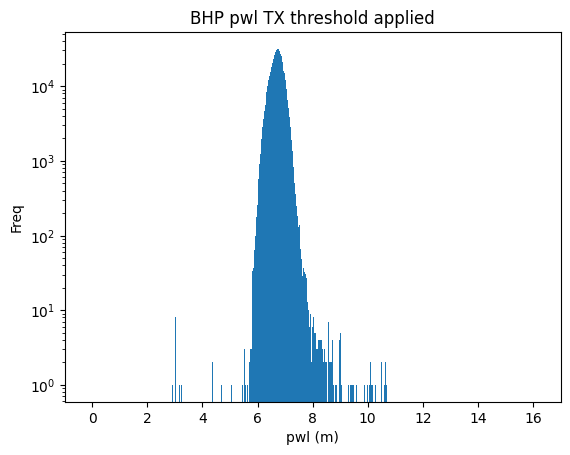

In [107]:
plt.hist(bhp['pwl'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl TX threshold applied')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

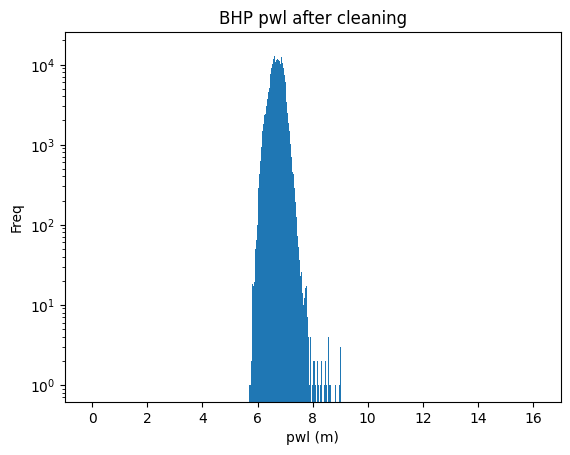

In [108]:
plt.hist(bhp['pwl_cleaned'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl after cleaning')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

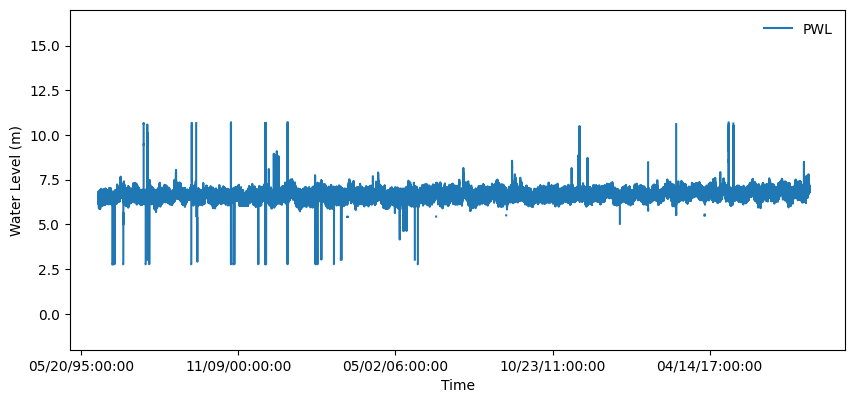

In [109]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2021/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl'], label='PWL')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

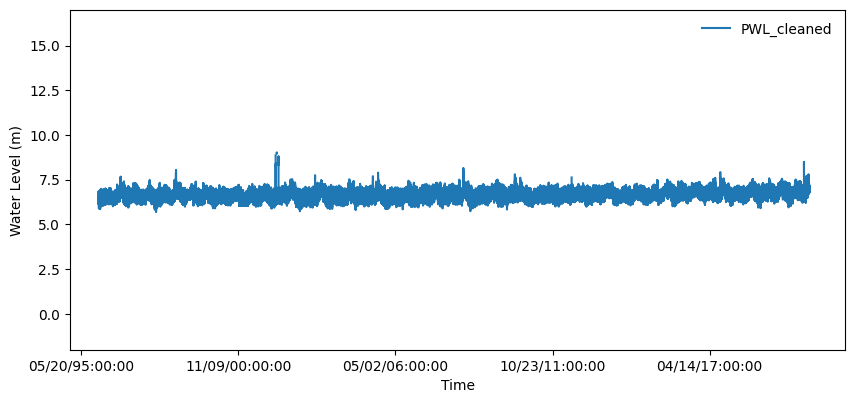

In [110]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2021/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl_cleaned'], label='PWL_cleaned')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

In [ ]:
bhp[41420:41450]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,false_positive_exception,spike_repeat_flag,gradient_flag,pwl_cleaned
41420,1996-06-21 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,0,NaN
41421,1996-06-21 14:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,0,NaN
41422,1996-06-21 14:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,0,NaN
41423,1996-06-21 14:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,0,NaN
41424,1996-06-21 14:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,0,NaN
41425,1996-06-21 14:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,0,NaN
41426,1996-06-21 14:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,0,NaN
41427,1996-06-21 14:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,0,NaN
41428,1996-06-21 14:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,0,NaN
41429,1996-06-21 14:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,0,NaN


In [ ]:
bhp['pwl_cleaned'].isna().sum() - bhp['pwl'].isna().sum()

np.int64(15014)

In [ ]:
suspects_df = bhp.dropna(subset=['pwl'])
suspects_df['suspect_flag'].sum()

np.int64(306)

In [ ]:
for col in ['3DF', '3DFm1', '3DFm2', '3DFm3', '3DB', '3DBm1', '3DBm2', '3DBm3']:
    mean = bhp[col].mean(skipna=True)
    std = bhp[col].std(skipna=True)
    upper = mean + 6 * std
    lower = mean - 6 * std
    print(f"{col}: mean={mean:.4f}, std={std:.4f}, range=({lower:.4f}, {upper:.4f})")


3DF: mean=0.0000, std=0.1025, range=(-0.6148, 0.6148)
3DFm1: mean=-0.0000, std=0.0985, range=(-0.5907, 0.5907)
3DFm2: mean=0.0001, std=0.1004, range=(-0.6022, 0.6023)
3DFm3: mean=-0.0000, std=0.0998, range=(-0.5985, 0.5985)
3DB: mean=-0.0000, std=0.1025, range=(-0.6148, 0.6148)
3DBm1: mean=0.0000, std=0.0998, range=(-0.5985, 0.5985)
3DBm2: mean=-0.0001, std=0.1004, range=(-0.6023, 0.6022)
3DBm3: mean=-0.0000, std=0.1025, range=(-0.6148, 0.6148)


In [ ]:
bhp['pwl_cleaned'].idxmax()

149619

In [ ]:
bhp[149600:149640]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,false_positive_exception,spike_repeat_flag,gradient_flag,pwl_cleaned
149600,1997-09-15 08:00:00,8.413,1.896,-1.456,1.163,1.088,3.212,-1.568,3.175,3.212,1,1,1,1,1,1,1,1,0,0,0,0,NaN
149601,1997-09-15 08:06:00,8.458,-1.268,1.851,1.326,-1.293,-1.613,-1.536,-1.551,-1.613,1,1,1,1,1,1,1,1,0,0,0,0,NaN
149602,1997-09-15 08:12:00,6.877,1.846,0.313,0.448,0.973,0.045,-0.008,0.058,0.045,1,0,0,1,0,0,0,0,0,1,0,0,6.877
149603,1997-09-15 08:18:00,6.882,-3.212,1.841,-2.902,-3.037,-0.013,-0.022,-0.010,-0.013,1,1,1,1,0,0,0,0,0,1,0,0,6.882
149604,1997-09-15 08:24:00,6.860,1.613,-3.190,-3.175,1.568,-0.000,1.056,1.053,-0.000,1,1,1,1,1,1,1,1,0,0,0,0,NaN
149605,1997-09-15 08:30:00,6.856,-0.045,1.617,1.551,1.536,1.060,-2.210,-2.228,1.060,0,1,1,1,1,1,1,1,0,0,0,0,NaN
149606,1997-09-15 08:36:00,6.857,0.013,-0.046,-0.058,0.008,-2.211,1.481,-1.732,-2.211,0,0,0,0,1,1,1,1,0,1,0,0,6.857
149607,1997-09-15 08:42:00,6.863,0.000,0.007,0.010,0.022,1.475,0.506,0.731,1.475,1,0,0,0,1,0,1,1,0,0,0,0,NaN
149608,1997-09-15 08:48:00,7.934,-1.060,-1.071,-1.053,-1.056,-0.565,-1.125,-1.887,-0.565,1,1,1,1,0,1,1,0,0,0,0,0,NaN
149609,1997-09-15 08:54:00,7.859,2.211,-0.985,2.228,2.210,-1.050,3.519,3.465,-1.050,1,1,1,1,1,1,1,1,0,0,0,0,NaN


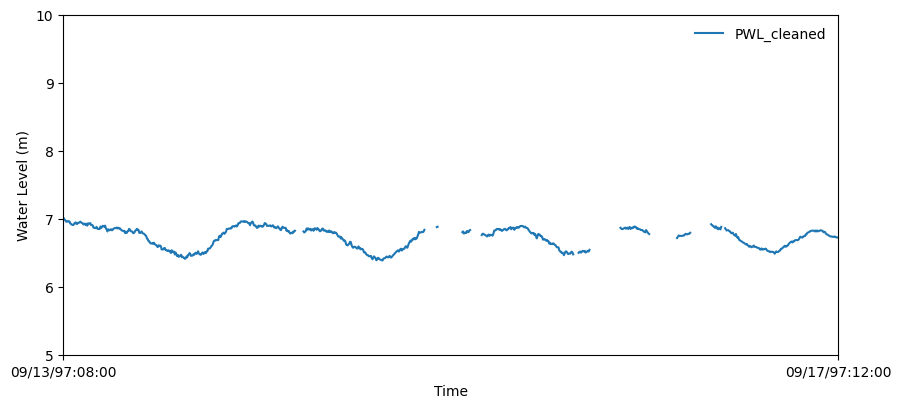

In [ ]:
start_date = pd.to_datetime('1997-09-13 08:00:00')
end_date = pd.to_datetime('1997-09-17 12:00:00')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl_cleaned'], label='PWL_cleaned')
#plt.plot(filtered_data['date'], filtered_data['pwl'], label='PWL')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(5,10)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

In [111]:
bhp['pwl_cleaned'].idxmax()

543887

In [113]:
bhp[543877:543927]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,false_positive_exception,spike_repeat_flag,gradient_flag,pwl_cleaned
543877,2002-03-16 03:42:00,9.071,0.012,0.009,-0.006,0.003,0.008,-0.040,-0.007,0.008,0,0,0,0,0,0,0,0,0,0,0,1,NaN
543878,2002-03-16 03:48:00,9.059,-0.021,0.024,-0.033,-0.018,-0.028,0.013,0.019,-0.028,0,0,0,0,0,0,0,0,0,0,0,1,NaN
543879,2002-03-16 03:54:00,9.048,0.006,-0.010,-0.046,0.011,0.024,0.013,0.076,0.024,0,0,0,0,0,0,0,0,0,0,0,1,NaN
543880,2002-03-16 04:00:00,9.046,-0.008,0.008,-0.025,0.011,0.015,-0.045,0.003,0.015,0,0,0,0,0,0,0,0,0,0,0,1,NaN
543881,2002-03-16 04:06:00,9.025,0.028,0.013,0.007,0.040,-0.024,-0.008,-0.020,-0.024,0,0,0,0,0,0,0,0,0,0,0,1,NaN
543882,2002-03-16 04:12:00,9.009,-0.024,0.044,-0.019,-0.013,0.008,-0.005,-0.005,0.008,0,0,0,0,0,0,0,0,0,0,0,1,NaN
543883,2002-03-16 04:18:00,9.013,-0.015,-0.028,-0.076,-0.013,-0.009,0.015,0.003,-0.009,0,0,0,0,0,0,0,0,0,0,0,0,9.013
543884,2002-03-16 04:24:00,9.013,0.024,-0.015,-0.003,0.045,0.015,-0.029,-0.026,0.015,0,0,0,0,0,0,0,0,0,0,0,0,9.013
543885,2002-03-16 04:30:00,9.017,-0.008,0.020,0.020,0.008,-0.033,0.031,0.004,-0.033,0,0,0,0,0,0,0,0,0,0,0,0,9.017
543886,2002-03-16 04:36:00,9.016,0.009,-0.007,0.005,0.005,0.032,0.004,0.046,0.032,0,0,0,0,0,0,0,0,0,0,0,0,9.016


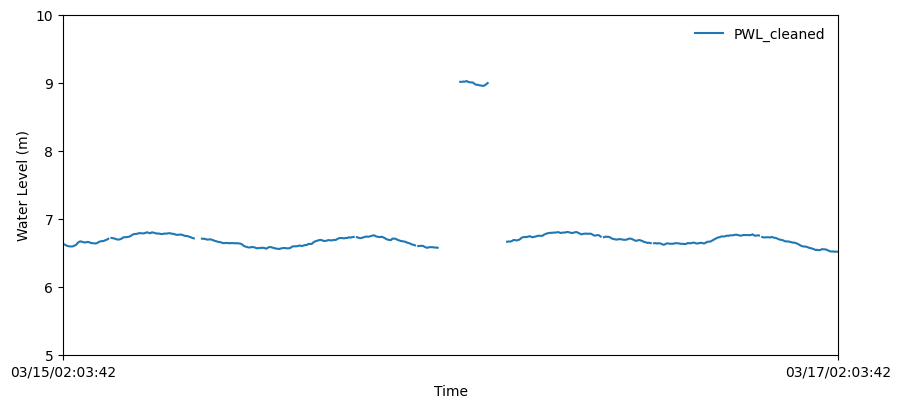

In [116]:
start_date = pd.to_datetime('2002-03-15 03:42:00')
end_date = pd.to_datetime('2002-03-17 03:42:00')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl_cleaned'], label='PWL_cleaned')
#plt.plot(filtered_data['date'], filtered_data['pwl'], label='PWL')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(5,10)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

In [115]:
bhp['gradient_flag'].sum()

np.int64(28)

When limiting the gradient test to only 1 hr and 2m smaller spikes surounded by NANs are able to pass through such as the example above, this is the new max of the dataset (9.016)

However total number of points flagged and removed by the gradient test are 28 total points, and if removing the limit of one hour the total amount is 35 total points

Another possible and final check could be to track values within the 1hr limit and values outside of the 1hr limit and compare the values over 1hr with points generated from the neural net


TESTING GAP FILLING FROM 2014 METHOD

In [ ]:
bhp_moving = bhp[['date', 'pwl_cleaned']].copy()